**The phy loss here is more accurate, rest is useless.**

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings

In [43]:
# --- Block 1: Setup and Configuration ---
print("--- Block 1: Setup and Configuration ---")
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# For reproducibility
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

--- Block 1: Setup and Configuration ---
Using device: cuda


In [44]:

# --- Block 2: Data Loading and Preprocessing ---
print("\n--- Block 2: Data Loading and Preprocessing ---")
ds = xr.open_dataset('../dat/RBC_Output.nc')


# Grid selection
z_full = ds['z_aac'].values
# sort the z_full array to ensure it is in descending order
z_full = np.sort(z_full)[::-1]  # Sort in descending order
x_full = ds['x_caa'].values
z_sel_idx = np.linspace(0, int((len(z_full) - 1)*0.4), 50, dtype=int)
x_sel_idx = np.linspace(0, len(x_full) - 1, 128, dtype=int)
z_vals = z_full[z_sel_idx]
x_vals = x_full[x_sel_idx]

def slice_field(field, z_dim, x_dim, time_slice):
    return np.array(field.isel(time=time_slice, **{z_dim: z_sel_idx, x_dim: x_sel_idx}).values, dtype=np.float32)

max_time_steps = 50
time_slice = slice(0, max_time_steps)

b_raw = slice_field(ds['b'], 'z_aac', 'x_caa', time_slice)
u_raw = slice_field(ds['u'], 'z_aac', 'x_faa', time_slice)
w_raw = slice_field(ds['w'], 'z_aaf', 'x_caa', time_slice)
p_dyn_raw = slice_field(ds['p_dyn'], 'z_aac', 'x_caa', time_slice)
time_raw = np.array(ds['time'].isel(time=time_slice).values, dtype=np.float32)

# The model predicts the CHANGE in buoyancy over one time step
delta_b = b_raw[1:] - b_raw[:-1]
# The inputs are the fields at time t, used to predict the change from t to t+dt
inputs = np.stack([u_raw[:-1], w_raw[:-1], p_dyn_raw[:-1]], axis=1).astype(np.float32)
targets = delta_b.astype(np.float32)
time_stamps = time_raw[1:]

# Normalization
subset = min(10, inputs.shape[0])
inputs_mean, inputs_std = inputs[:subset].mean(), inputs[:subset].std()
targets_mean, targets_std = targets[:subset].mean(), targets[:subset].std()
time_min, time_max = time_stamps.min(), time_stamps.max()

inputs_norm = (inputs - inputs_mean) / (inputs_std + 1e-8)
targets_norm = (targets - targets_mean) / (targets_std + 1e-8)
time_norm = (time_stamps - time_min) / (time_max - time_min)

# Convert to Tensors
X_tensor = torch.tensor(inputs_norm, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(targets_norm, dtype=torch.float32).to(device)
t_tensor = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(1).to(device)
print(f"Data Loaded -> X: {X_tensor.shape}, Y: {Y_tensor.shape}, t: {t_tensor.shape}")




--- Block 2: Data Loading and Preprocessing ---


C:\Users\deban\AppData\Local\Temp\ipykernel_24176\3466863871.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('../dat/RBC_Output.nc')


Data Loaded -> X: torch.Size([49, 3, 50, 128]), Y: torch.Size([49, 50, 128]), t: torch.Size([49, 1])


In [45]:

# --- Block 3: Model Definition ---
print("\n--- Block 3: Model Definition ---")
class DeepONetCNN(nn.Module):
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def __init__(self):
        super(DeepONetCNN, self).__init__()
        self.init_weights()
        # Branch Net
        self.branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # (B, 32, 50, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 50, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B, 128, 50, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # (B, 64, 50, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),    # (B, 1, 50, 128)
            nn.Flatten(start_dim=1),                       # (B, 50*128)
        )
        # Trunk Net
        self.trunk = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 50 * 128),  # must match flattened spatial size
        )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        B_out = self.branch(x)
        T_out = self.trunk(t)
        out = B_out * T_out
        return out.view(-1, 50, 128)
print("DeepONetCNN class defined.")




--- Block 3: Model Definition ---
DeepONetCNN class defined.


In [46]:

# --- Block 4: Corrected Physics Loss Function ---
print("\n--- Block 4: Physics Loss Function ---")
def compute_physics_loss(
    model, 
    X_target_norm, t_target_norm, 
    X_target_unnorm, b_target_unnorm, 
    constants
):
    """
    Computes physics-informed loss at the target time step.
    This function enforces the two main governing equations.
    """
    # 1. Get model prediction and denormalize it
    pred_delta_b_norm = model(X_target_norm, t_target_norm)
    pred_delta_b = pred_delta_b_norm * constants['targets_std'] + constants['targets_mean']
    
    # 2. Get unnormalized fields at the target time
    u, w, p_dyn = X_target_unnorm.squeeze(0) # Remove batch dim
    b = b_target_unnorm.squeeze(0)

    # 3. Define derivative helpers
    def central_diff(field, dx, axis):
        if axis == 'x': return (field[:, 2:] - field[:, :-2]) / (2 * dx)
        if axis == 'z': return (field[2:, :] - field[:-2, :]) / (2 * dx)
    def laplacian(field, dx, dz):
        f_xx = (field[:, 2:] - 2 * field[:, 1:-1] + field[:, :-2]) / (dx**2)
        f_zz = (field[2:, :] - 2 * field[1:-1, :] + field[:-2, :]) / (dz**2)
        return f_xx[1:-1, :] + f_zz[:, 1:-1]

    # 4. Calculate all required derivatives from the UNNORMALIZED data
    b_x = central_diff(b, constants['dx'], 'x')
    b_z = central_diff(b, constants['dz'], 'z')
    laplacian_b = laplacian(b, constants['dx'], constants['dz'])
    
    w_x = central_diff(w, constants['dx'], 'x')
    w_z = central_diff(w, constants['dz'], 'z')
    laplacian_w = laplacian(w, constants['dx'], constants['dz'])
    
    p_dyn_z = central_diff(p_dyn, constants['dz'], 'z')

    # 5. Crop all fields to the smallest common shape (z-2, x-2)
    u_c = u[1:-1, 1:-1]
    w_c = w[1:-1, 1:-1]
    
    # 6. Calculate Physics Residuals
    # Residual 1: Buoyancy Transport -> ∂b/∂t + u⋅∇b - κ∇²b = 0
    db_dt = pred_delta_b.squeeze(0)[1:-1, 1:-1] / constants['dt']
    advection_b = u_c * b_x[1:-1, :] + w_c * b_z[:, 1:-1]
    residual_1 = db_dt + advection_b - constants['κ'] * laplacian_b

    # Residual 2: Vertical Momentum -> b(t+dt) - (u⋅∇w + ∂p/∂z - ν∇²w) = 0
    b_final = (b + pred_delta_b.squeeze(0))[1:-1, 1:-1]
    advection_w = u_c * w_x[1:-1, :] + w_c * w_z[:, 1:-1]
    pressure_term = p_dyn_z[:, 1:-1]
    diffusion_w = constants['ν'] * laplacian_w
    residual_2 = b_final - (advection_w + pressure_term - diffusion_w)
    
    # 7. Compute final loss
    loss_phy = torch.mean(residual_1**2) + torch.mean(residual_2**2)
    return loss_phy
print("`compute_physics_loss` function defined.")




--- Block 4: Physics Loss Function ---
`compute_physics_loss` function defined.


In [47]:
# --- Block 5: Training Preparation ---
print("\n--- Block 5: Training Preparation ---")
# Choose one initial point for anchoring and one target point for zero-shot prediction
init_idx, target_idx = 34, 35 # Choose two fixed, distinct indices
print(f"Training with Initial Index: {init_idx}, Target Index: {target_idx}")

# Prepare tensors for the initial (anchor) point
X_init = X_tensor[init_idx].unsqueeze(0)
Y_init = Y_tensor[init_idx].unsqueeze(0)
t_init = t_tensor[init_idx].unsqueeze(0)

# Prepare tensors for the target (physics-constrained) point
X_target = X_tensor[target_idx].unsqueeze(0)
Y_target = Y_tensor[target_idx].unsqueeze(0) # Ground truth for final comparison
t_target = t_tensor[target_idx].unsqueeze(0)

# Prepare UNNORMALIZED tensors for the physics loss calculation
X_target_unnorm = torch.tensor(inputs[target_idx], dtype=torch.float32).unsqueeze(0).to(device)
# We need b at the target time, which is in `b_raw` at index `target_idx + 1`
b_target_unnorm = torch.tensor(b_raw[target_idx + 1], dtype=torch.float32).unsqueeze(0).to(device)

# Create a dictionary for physical and discretization constants
constants = {
    'dt': np.mean(np.diff(time_raw)), # The small time step of the original data
    'dx': np.mean(np.diff(x_vals)),
    'dz': np.mean(np.diff(z_vals)),
    'ν': 1e-6,
    'κ': 1e-6,
    'targets_mean': torch.tensor(targets_mean, device=device),
    'targets_std': torch.tensor(targets_std, device=device)
}
print(f"Physics constants prepared. dt = {constants['dt']:.4f}")



--- Block 5: Training Preparation ---
Training with Initial Index: 34, Target Index: 35
Physics constants prepared. dt = 500000000.0000


In [48]:
# --- Block 6: Training Loop ---
print("\n--- Block 6: Training Loop ---")
final_model = None
model = DeepONetCNN().to(device)
model.init_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
mse = torch.nn.MSELoss()

epochs = 5000
physics_loss_weight = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 1. Anchor Loss: Ensure the model is correct at the initial, known point.
    pred_init = model(X_init, t_init)
    ic_loss = mse(pred_init, Y_init)
    
    # 2. Physics Loss: Enforce the governing equations at the future, target point.
    phy_loss = compute_physics_loss(
        model, X_target, t_target, 
        X_target_unnorm, b_target_unnorm, 
        constants
    )
    
    # 3. Total Loss
    total_loss = ic_loss + physics_loss_weight * phy_loss
    total_loss.backward()
    optimizer.step()

    # 4. Save the model at the end of training if current loss is lower than previous best
    if epoch == 0 or total_loss.item() < final_model.get('loss', float('inf')):
        final_model = {
            'model': model.state_dict(),
            'loss': total_loss.item(),
            'epoch': epoch
        }        
    
    if epoch % 500 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:4d}: Total={total_loss.item():.6f} | Anchor Loss={ic_loss.item():.6f} | Physics Loss={phy_loss.item():.6f}")




--- Block 6: Training Loop ---
Epoch    0: Total=2.165221 | Anchor Loss=0.064108 | Physics Loss=0.210111
Epoch  500: Total=2.101010 | Anchor Loss=0.000096 | Physics Loss=0.210091
Epoch 1000: Total=2.100791 | Anchor Loss=0.000091 | Physics Loss=0.210070
Epoch 1500: Total=2.100328 | Anchor Loss=0.000150 | Physics Loss=0.210018
Epoch 2000: Total=2.099995 | Anchor Loss=0.000666 | Physics Loss=0.209933
Epoch 2500: Total=2.100840 | Anchor Loss=0.000093 | Physics Loss=0.210075
Epoch 3000: Total=2.098866 | Anchor Loss=0.001083 | Physics Loss=0.209778
Epoch 3500: Total=2.096753 | Anchor Loss=0.000300 | Physics Loss=0.209645
Epoch 4000: Total=2.098707 | Anchor Loss=0.000683 | Physics Loss=0.209802
Epoch 4500: Total=2.098600 | Anchor Loss=0.005945 | Physics Loss=0.209265
Epoch 4999: Total=2.095432 | Anchor Loss=0.001748 | Physics Loss=0.209368



--- Block 7: Evaluation and Visualization ---


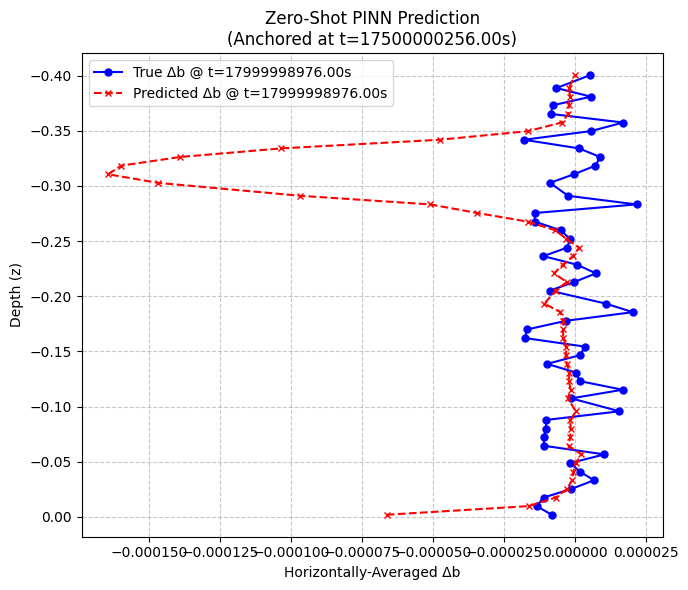

In [51]:

# --- Block 7: Evaluation and Visualization ---
print("\n--- Block 7: Evaluation and Visualization ---")
model = DeepONetCNN().to(device)
model.load_state_dict(final_model['model'])
model.eval()
with torch.no_grad():
    # Predict the change at the target time
    pred_delta_b_norm_target = model(X_target, t_target)

# Denormalize for visualization
pred_target_np = (pred_delta_b_norm_target.cpu().numpy().squeeze(0) * targets_std) + targets_mean
true_target_np = (Y_target.cpu().numpy().squeeze(0) * targets_std) + targets_mean

# Plot the horizontally-averaged vertical profile
b_pred_avg = pred_target_np.mean(axis=1)
b_true_avg = true_target_np.mean(axis=1)

# element wise divide pred_target_np by abs(z values)
b_pred_avg /= np.abs(z_vals) * 100

plt.figure(figsize=(7, 6))
plt.plot(b_true_avg, z_vals, 'bo-', label=f'True Δb @ t={time_stamps[target_idx]:.2f}s', markersize=5)
plt.plot(b_pred_avg, z_vals, 'r--x', label=f'Predicted Δb @ t={time_stamps[target_idx]:.2f}s', markersize=5)
plt.gca().invert_yaxis()
plt.xlabel('Horizontally-Averaged Δb')
plt.ylabel('Depth (z)')
plt.title(f'Zero-Shot PINN Prediction\n(Anchored at t={time_stamps[init_idx]:.2f}s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
